---
title: "Supervised Fine Tuning"
description: "A hands on guide to fine-tune a Large Language model using trl library"
date: "2024-12-23"
categories: 
  - trl
  - Fine-Tuning
image: "images/trl_banner_dark.png"
---

# Supervised Fine-Tuning with the `trl` Library



## Introduction: What is **Supervised Fine-Tuning (SFT)**?:
> Before understanding what SFT is, we should understand what pre-training is. Pre-training involves training a model (generally a transformer) on a large corpus of text. Pre-training allows models to learn generalizable knowledge, grammar, semantics etc. However, the model is hardly usable after pre-training; as the model lacks task specific expertize.

  > That's where Supervised Training plays a part. Supervised Fine-Tuning is used to adapt a pre-trained model to a specific task. It involves training the model on a labeled dataset, where the model learns to predict the correct label for each input.
  
  > In this article, we will load a pre-trained model from HuggingFace and finetune it on a specific dataset about Python programming.



## Install Required Packages
We need transformers, trl and datasets packages. We will install the packages using pip:  



In [1]:
!pip install -q transformers==4.47.1 trl==0.13.0 datasets==3.2.0

## Import Packages



In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from datasets import load_dataset
import os
import torch
import warnings
warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Load a Pretrained Model
> We will load `SmolLM2-135M` model and it's tokenizer from HuggingFace. After that, we will generate output of the model on a few specific input prompts related to Python. First, we ask a simple question of writing Python code for finding square of a number. After that, we ask model to determine if a string is palindrome (slightly difficult question than the first one).

  > As we can see, the model did not provide correct output in both the cases. The model generates some irrelevant text and keep repeating that afterwards. Let's see how finetuning this model on task-specific dataset will help in increasing the model correctness.



In [4]:
model_name = 'HuggingFaceTB/SmolLM2-135M'
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [5]:
input = 'Generate Python code for finding square of a number'
tokenized_input = tokenizer(input, return_tensors='pt').to(device)
model = model.to(device)
model.generation_config.pad_token_id = tokenizer.pad_token_id
output = model.generate(**tokenized_input, max_length=128)
print(tokenizer.decode(output[0]))

Generate Python code for finding square of a number

Python code to find square of a number

Python code to find square of a number

Python code to find square of a number

Python code to find square of a number

Python code to find square of a number

Python code to find square of a number

Python code to find square of a number

Python code to find square of a number

Python code to find square of a number

Python code to find square of a number

Python code to find square of a number

Python code to find square of a


In [46]:
input = 'Write a program in Python to determine if a string is a palindrome'
tokenized_input = tokenizer(input, return_tensors='pt').to(device)
model = model.to(device)
model.generation_config.pad_token_id = tokenizer.pad_token_id
output = model.generate(**tokenized_input, max_length=256)
print(tokenizer.decode(output[0]))

Write a program in Python to determine if a string is a palindrome.

```python
def is_palindrome(s):
    # Check if the string is a palindrome
    if not s:
        return False

    # Check if the string is a word
    if len(s) != 1:
        return False

    # Check if the string is a number
    if s.isdigit():
        return True

    # Check if the string is a letter
    if s.islower():
        return True

    # Check if the string is a letter
    if s.isupper():
        return True

    # Check if the string is a word
    if len(s) != 1:
        return False

    # Check if the string is a number
    if s.isnumeric():
        return True

    # Check if the string is a letter
    if s.islower():
        return True

    # Check if the string is a word
    if len(s) != 1:
        return False

    # Check if the string is a number
    if s.isnumeric():
        return True

    # Check if the string is a letter
    if s.isupper():
        return True

    # Check if the string is a

## Load Dataset
- We will only load a fraction of data (3 %) for the ease of training with a single GPU.
- Train dataset has around 15000 examples and test / evaluation dataset has 1679 examples.

In [18]:
dataset_path = 'jtatman/python-code-dataset-500k'
ds = load_dataset(dataset_path, split='train[:3%]')
ds = ds.train_test_split(test_size=0.1)
train_dataset = ds['train']
test_dataset = ds['test']

In [19]:
len(train_dataset)

15106

In [20]:
len(test_dataset)

1679

In [21]:
train_dataset

Dataset({
    features: ['output', 'instruction', 'system'],
    num_rows: 15106
})

## Define a Formatting Function
- As we can see from above, the dataset has 3 columns: system, instruction and output.
- For finetuning the model, we need to combine the 3 columns into a single text field (which is achieved with `formatting_function` function)

In [9]:
def formatting_function(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        individual_prompt = "###System: {}\n###Instruction: {}\n ###Output: {}".format(example['system'][i],
                                                                                       example['instruction'][i],
                                                                                       example['output'][i])
        output_texts.append(individual_prompt)
    return output_texts

## Define a Collator
- We also need to define a collator which needs response template and tokenizer as input.
- Response template will help the trainer to identify output within the training prompt. If the training examples do not contain the response template, trainer will error out.

In [10]:
response_template = " ###Output:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

## Training

### Define Training Config
- `trl` library provides `SFTConfig` class using which we can provide training arguements.
- We have used train and eval batch size of 2 due to memory constraints.
- We have also used Gradient Accumulation and Gradient Checkpointing for memory optimization.
- In addition, we have also used `bf16=True` in an effort to further optimize memory.

In [22]:
trainer_config = SFTConfig(
    output_dir='.\code_finetuned_mode',
    max_steps=1000,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=10,
    ignore_data_skip=True,
    run_name='code_fine_tuning_23_12_2024',
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch
    # Memory optimization
    gradient_checkpointing=True,  # Trade compute for memory savings
    optim="adamw_torch_fused",
    bf16=True
)

### Train / Finetune the model
- We will empty cache before starting training to optimize memory.
- `trl` library has `SFTTrainer` class to which we need to provide model, training arguments, training data, evaluation data, formatting function and data collator.
- Training information will get logged to Weights and Biases.
- We will save the trained model to a local directory.

In [23]:
torch.cuda.empty_cache()

In [24]:
trainer = SFTTrainer(
    model=model,
    args=trainer_config,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    formatting_func=formatting_function,
    data_collator=collator
)
trainer.train()

Map:   0%|          | 0/15106 [00:00<?, ? examples/s]

Map:   0%|          | 0/1679 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
100,0.743100,0.728401
200,0.835200,0.708747
300,0.641200,0.696030
400,0.726100,0.687549
500,0.691100,0.681275
600,0.687000,0.676701
700,0.682500,0.673061
800,0.701100,0.670183
900,0.672400,0.668563
1000,0.679100,0.668029


TrainOutput(global_step=1000, training_loss=0.7042460036277771, metrics={'train_runtime': 3947.6465, 'train_samples_per_second': 1.013, 'train_steps_per_second': 0.253, 'total_flos': 1717373605593600.0, 'train_loss': 0.7042460036277771, 'epoch': 0.26479544551833706})

### Training Loss
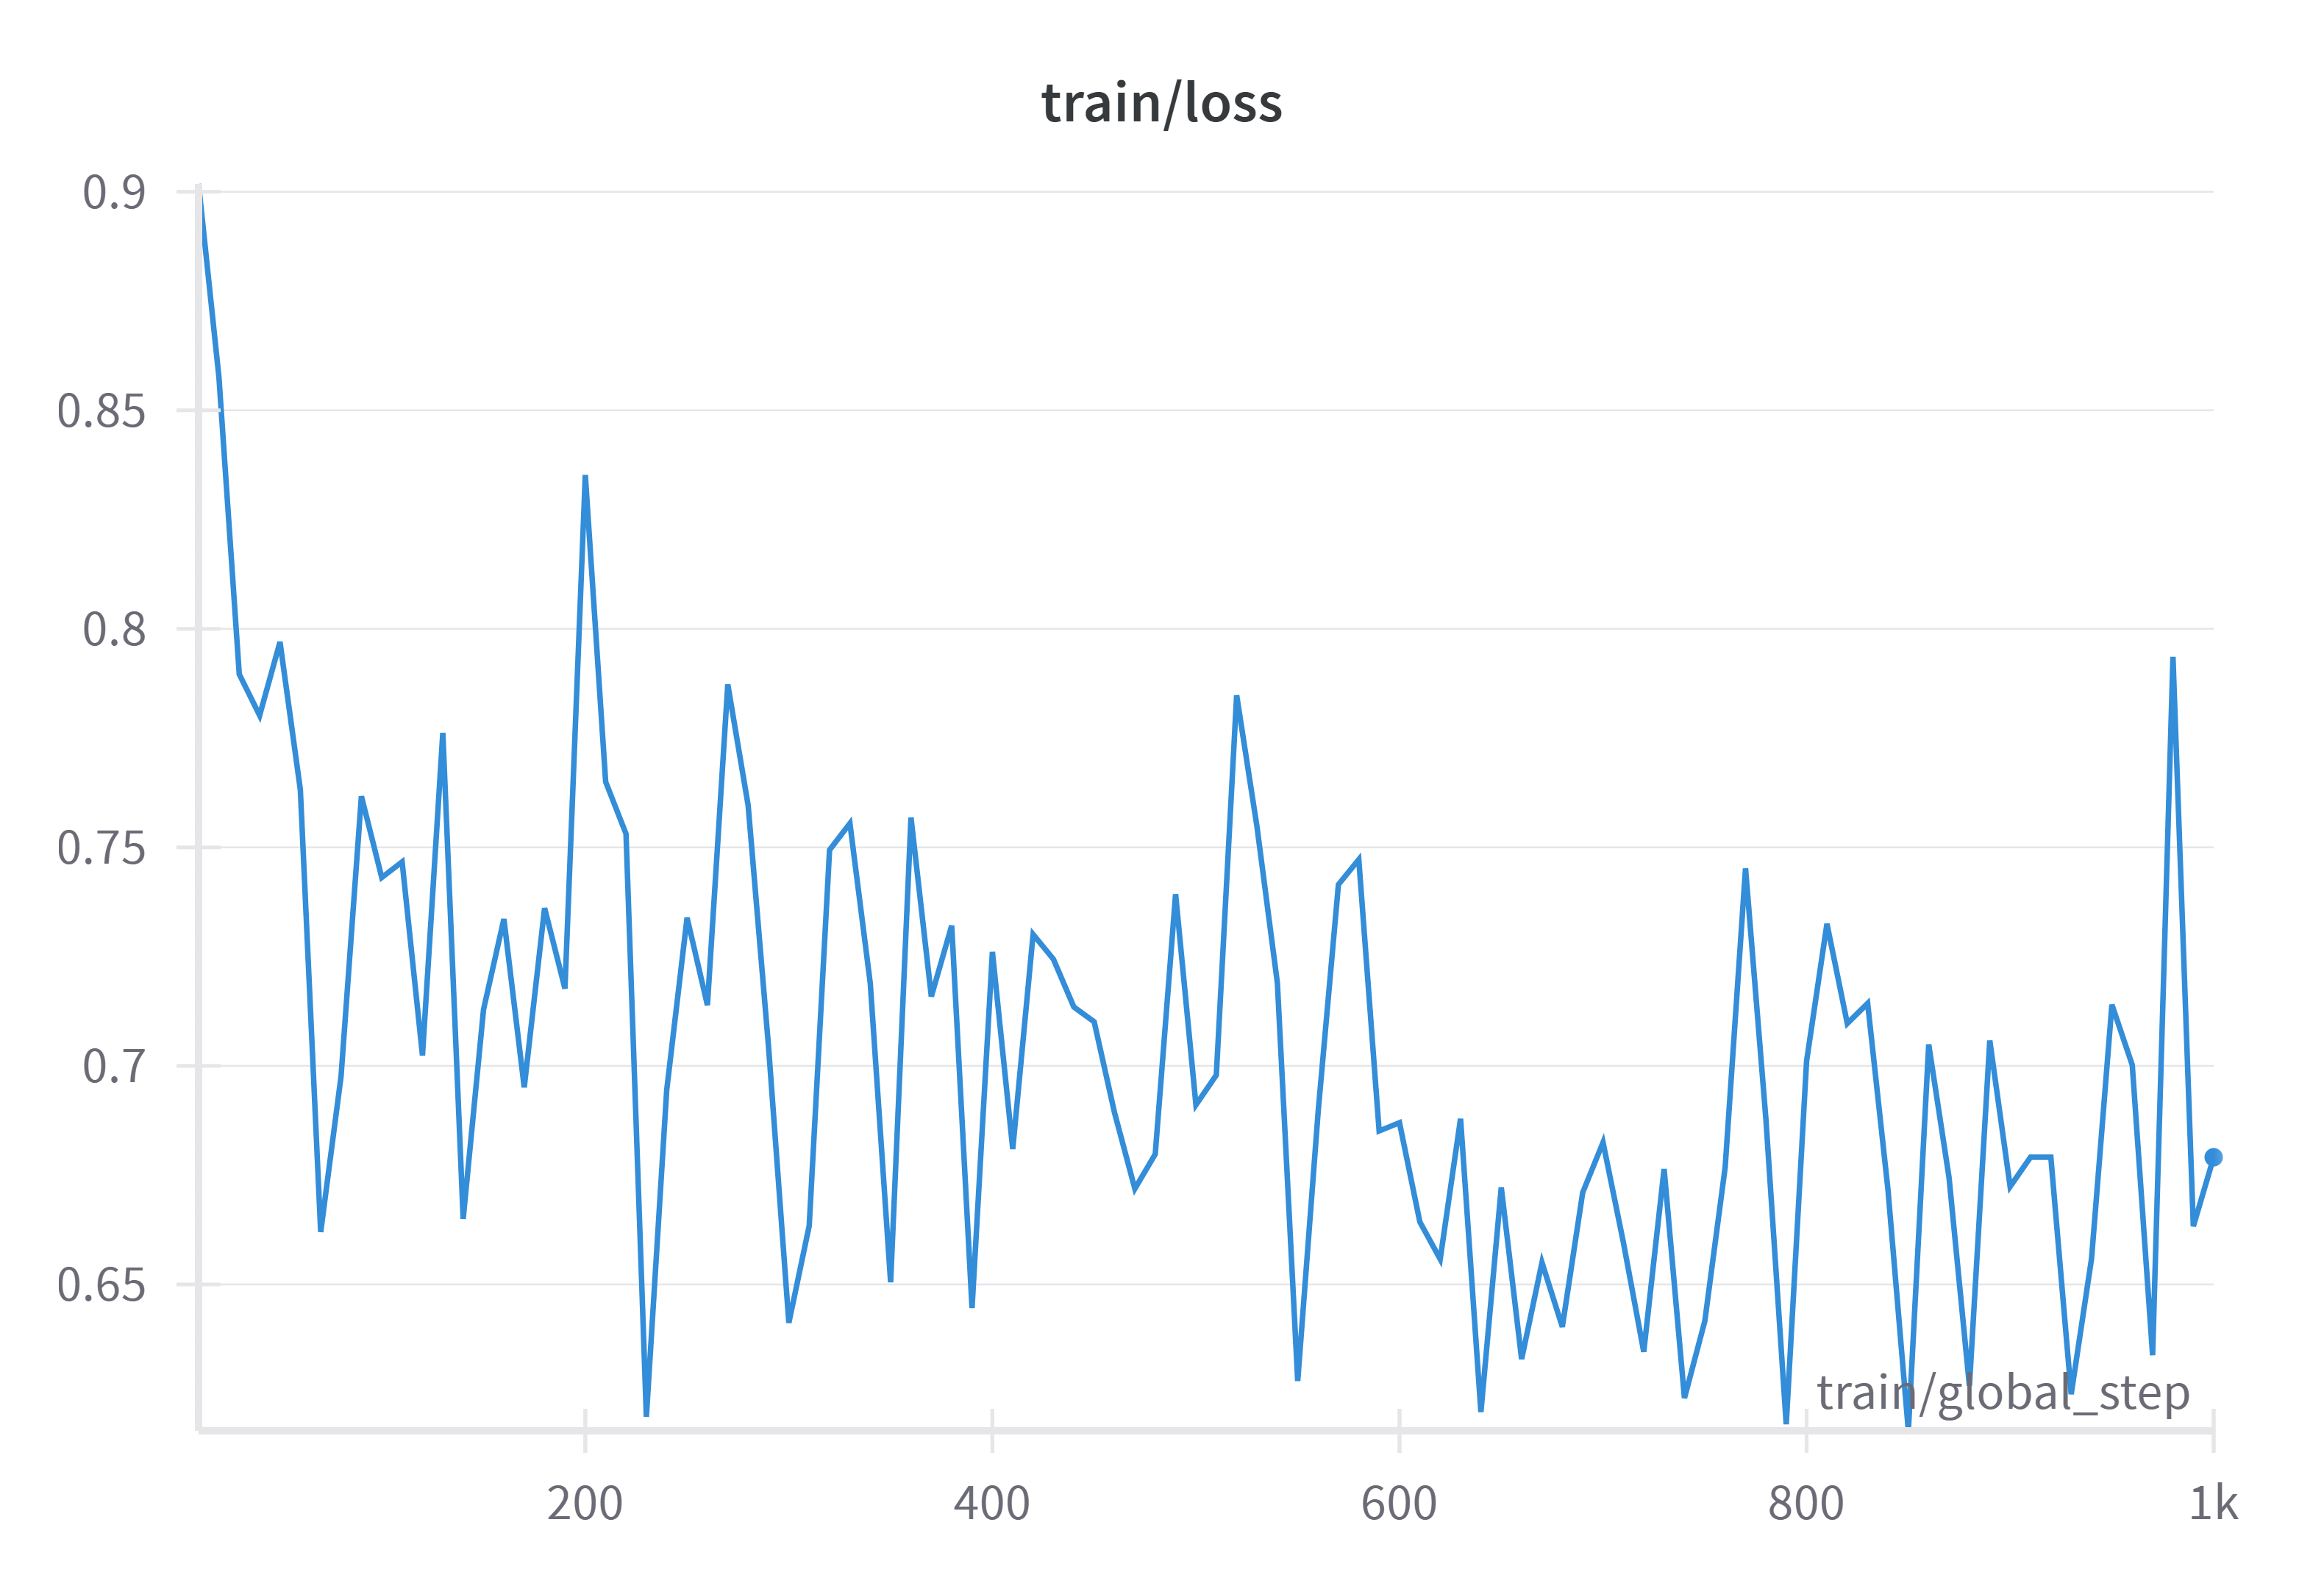





### Evaluation Loss
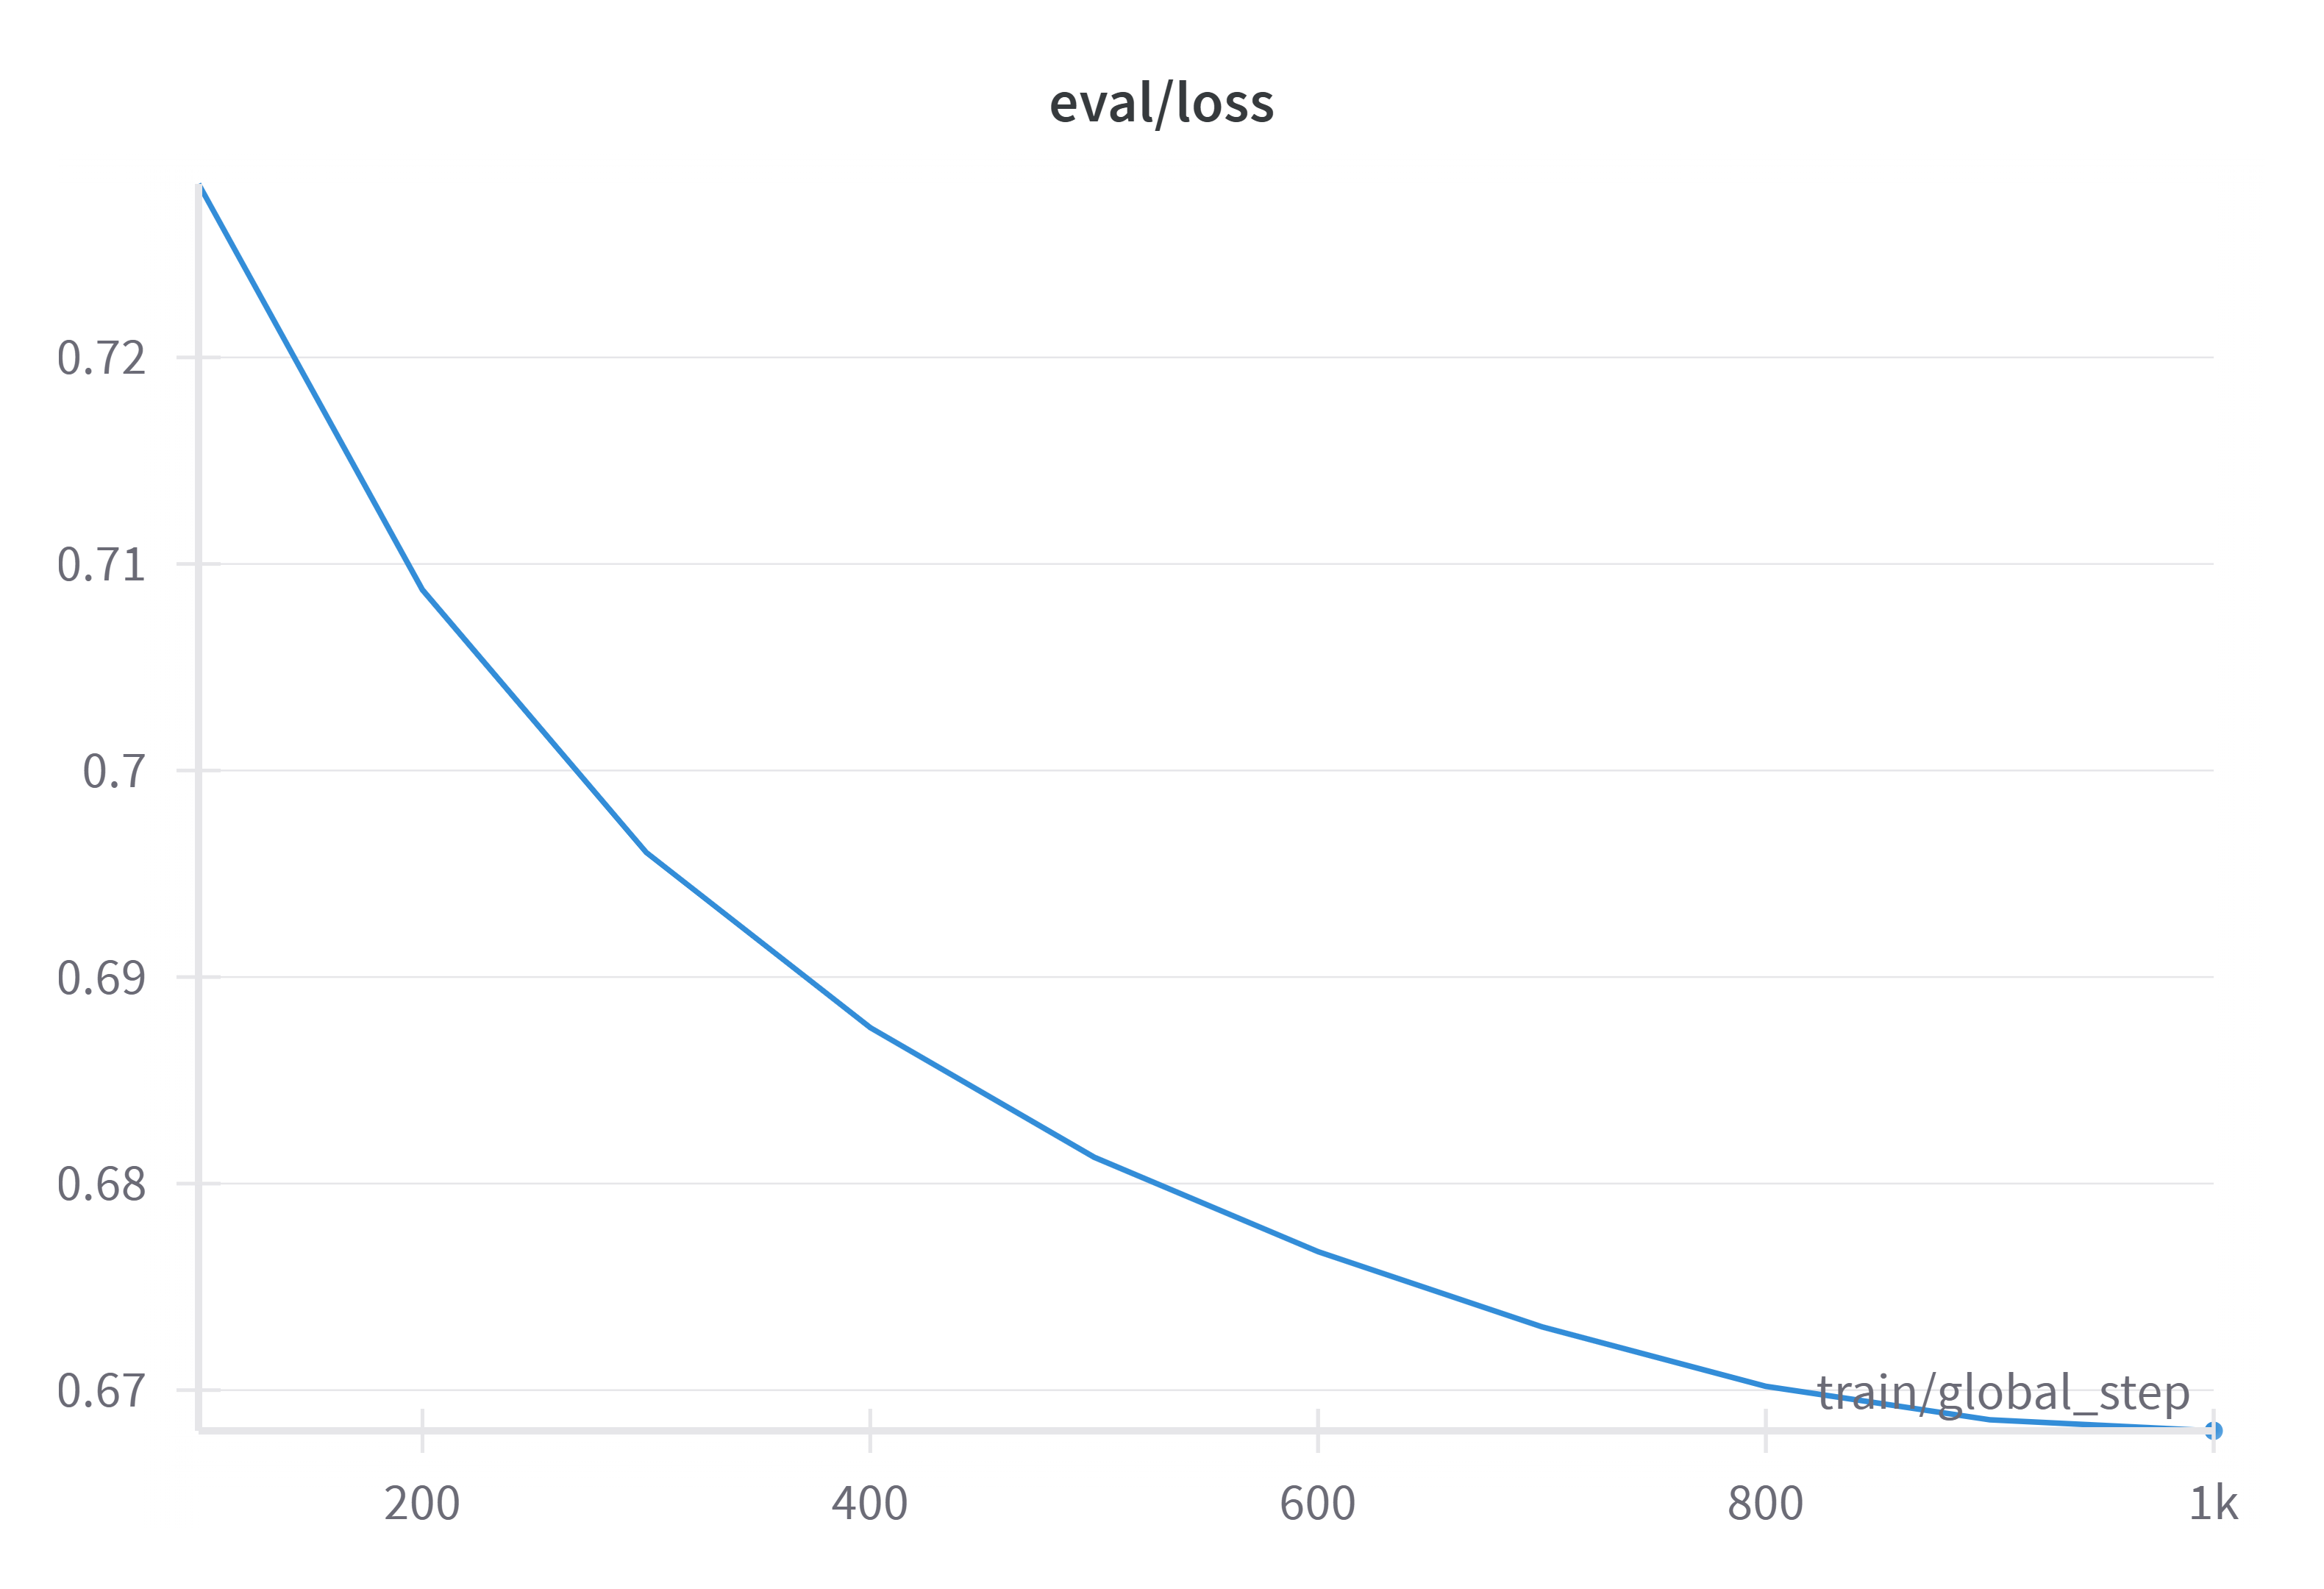

In [25]:
finetune_name = 'code_model_finetuned'

In [26]:
trainer.save_model(f'./{finetune_name}')

## Load the Finetuned Model and perform prediction with it
- As we can notice, the finetuned model has answered first question correctly.
- The model tried to answer second question. However, the answer is not correct. However, the output is quite better than the non fine-tuned model. It has written correct to determine if a string is palindrome when it's length is 2 :).
- Due to resource constraints, we used limited data and performed training for 1000 steps only. Considering that, I would say that the finetuned model is much better at Python coding than the baseline model.

In [31]:
finetuned_model = AutoModelForCausalLM.from_pretrained(f'./{finetune_name}', local_files_only=True)

In [32]:
input = """##System: You are a Python code generator, 
capable of creating scripts from specifications.\n
#Instruction: Generate Python code for finding square of a number"""
tokenized_input = tokenizer(input, return_tensors='pt')
finetuned_model.generation_config.pad_token_id = tokenizer.pad_token_id
output = finetuned_model.generate(**tokenized_input, max_length=128)
print(tokenizer.decode(output[0]))

##System: You are a Python code generator, capable of creating scripts from specifications.

#Instruction: Generate Python code for finding square of a number

Given a number, find the square of that number.

Example:

```python
number = 10
square_number = number ** 2
print(square_number)
```

Output:
```
10
```

Explanation:

```python
number = 10
square_number = number ** 2
print(square_number)
```

Output:
```
10


In [47]:
input = """##System: You are a Python code generator, 
capable of creating scripts from specifications.\n
#Instruction: Write a program in Python to determine if a string is a palindrome
"""
tokenized_input = tokenizer(input, return_tensors='pt')
finetuned_model.generation_config.pad_token_id = tokenizer.pad_token_id
output = finetuned_model.generate(**tokenized_input, max_length=256)
print(tokenizer.decode(output[0]))

##System: You are a Python code generator, capable of creating scripts from specifications.

#Instruction: Write a program in Python to determine if a string is a palindrome

A palindrome is a word or a string that reads the same backward and forward. For example, the word "hello" is a palindrome because it reads the same backward and forward.

Here's a program that determines if a string is a palindrome:

```python
def is_palindrome(string):
    # Check if the string is empty
    if len(string) == 0:
        return False

    # Check if the string is a word
    if len(string) == 2:
        # Check if the first character is the same as the last character
        if string[0] == string[-1]:
            return True
        else:
            return False

    # Check if the string is a word
    if len(string) == 1:
        return string[0] == string[-1]

    # Check if the string is a word
    if string[0] != string[-1]:
        return False

    # Check if the string is a word
    if str

## Conclusion
- `trl` library provides high level and quite simple APIs to finetune a Large Language model.
- Following are Pros and Cons of the finetuning approach described in this article:
  - **Pros**:
    - **Improved Task Performance**: Fine-tuning enables a model to specialize in specific tasks, often achieving better accuracy compared to general-purpose models.
    - **Data Efficiency**: Requires much less labeled data compared to training from scratch due to pre-trained knowledge.
    - **Customizability**: Allows tailoring models to domain-specific or task-specific needs (e.g., medical, legal, or financial contexts).
  - **Cons**:
    - **Risk of Overfitting**: On small datasets, the model may overfit, reducing its ability to generalize to unseen data.
    - **Catastrophic Forgetting**: Fine-tuning can overwrite pre-trained knowledge, reducing performance on general tasks.
    - **Resource Requirements**: Fine-tuning still demands significant computational resources, especially for large models, compared to lightweight alternatives like prompt engineering.
    - **Updation of All Parameters**: The finetuning approach described in this article updates all parameters of the model. Therefore, storing of the updated model is quite costly. Therefore, more efficient approaches of finetuning like PEFT and LoRA are preferred.







## References:
1.   [TRL (Transformer Reinforcement Learning) Documentation](https://huggingface.co/docs/trl/en/index):
2.   [SmolLM2-135M Model on HuggingFace](https://huggingface.co/HuggingFaceTB/SmolLM2-135M)
3. [Dataset for Training](https://huggingface.co/datasets/jtatman/python-code-dataset-500k)

